In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce

# **General functions**

In [ ]:
# Functions for detecting missing values
def print_separator(sep, num, msg):
  print('\n')
  print(sep * num)
  print(f'{msg}')
  print(sep * num)


# Tactic 1: Looking at all the unique values
def look_at_unique_values(column):
  unique_values_cutoff = 30
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f'Each value in the column is unique (total: {num_unique_values})')
  elif num_unique_values < len(column):
    print(f'Less than {len(column)} unique values (total: {num_unique_values})')
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print('Values are sorted')
      display(list(sorted))
    except:
      print('Could not sort values')
      display(list(unique_values))
    else:
      print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


# Tactic 2: Sorting and looking at the edges
def look_at_edges(df, column_name):
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print('Unique values sorted, head and tail:')
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f'Could not sort values: {error}')
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)


# Tactic 3: Casting to a type
def cast_to_type(column, data_type_column):
  try:
    column.astype(data_type_column)
    print(f'Casting to {data_type_column} was successful')
  except ValueError as error:
    print(f'Could not cast to {data_type_column}: {error}')


# Find non-default missing values in the dataset
def find_non_default_missing_values(df, column_name, data_type_column):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator('*', long_separator_amount, f'Finding non-default missing values for column \'{column_name}\'')

  print(f'Column \'{column_name}\' has datatype: {df.dtypes[column_name]}')

  column = df[column_name]  

  # A Looking at all the unique values
  print_separator('-', short_separator_amount, 'A: Looking at unique values')
  look_at_unique_values(column)

  # B Sorting and looking at the edges
  print_separator('-', short_separator_amount, 'B: Sorting and looking at the edges')
  look_at_edges(df, column_name)

  # C Casting to a type
  print_separator('-', short_separator_amount, f'C: Casting to type: {data_type_column}')
  cast_to_type(column, data_type_column)

  # D Looking at the frequency
  print_separator('-', short_separator_amount, 'D: Looking at frequency')
  display(column.value_counts(dropna=False))

  print('\n')

In [ ]:
# Replace values
def replace_value(df, column_name, missing_old, missing_new):
  df[column_name] = df[column_name].replace({missing_old: missing_new})

# **Question 1: Data preparation**

In [ ]:
# Prepare dataset
files_list = ['/content/drive/MyDrive/EindopdrachtWinc/Co2EmissionPerCapita.csv', 
              '/content/drive/MyDrive/EindopdrachtWinc/Population.csv', 
              '/content/drive/MyDrive/EindopdrachtWinc/GDPPerCapita.csv', 
              '/content/drive/MyDrive/EindopdrachtWinc/FossilFuelConsumptionPerCapita.csv', 
              '/content/drive/MyDrive/EindopdrachtWinc/AgriculturalLandPerCapita.csv', 
              '/content/drive/MyDrive/EindopdrachtWinc/Deforestation.csv', 
              '/content/drive/MyDrive/EindopdrachtWinc/MeatProduction.csv']

dfs_list = []

# Read every file in the list and create a list of dataframes
for file in files_list:
  df = pd.read_csv(file)
  dfs_list.append(df)

# Merge the dataframes
co2_emission_predictor_df = reduce(lambda left, right: pd.merge(left, right, on = ['Entity', 'Code', 'Year'], how = 'left'), dfs_list)

# Drop columns
co2_emission_predictor_df.drop(columns=['Population (future projections)', '417485-annotations'], inplace=True)

# Rename columns
co2_emission_predictor_df.rename(columns={'Entity' : 'Country', 'Code' : 'Country_code', 
                                           'Annual CO₂ emissions (per capita)' : 'CO2_emission(tonnes_per_capita)', 
                                           'Population (historical estimates)' : 'Population', 
                                           'GDP per capita' : 'GDP_per_capita', 
                                           'Coal per capita (kWh)' : 'Coal_per_capita_(kWh)', 
                                           'Oil per capita (kWh)' : 'Oil_per_capita_(kWh)',
                                           'Gas per capita (kWh)' : 'Gas_per_capita_(kWh)', 
                                           'agricultural_land_per_capita' : 'Agricultural_land_per_capita', 
                                           'Deforestation' : 'Deforestation_(ha)', 
                                           'Meat, total | 00001765 || Production | 005510 || tonnes' : 'Meat_production_(tonnes)'}, 
                                  inplace=True)

# Use only countries
co2_emission_predictor_df.dropna(subset=['Country_code'], inplace=True)
co2_emission_predictor_df.drop(co2_emission_predictor_df.loc[co2_emission_predictor_df['Country'] == 'World'].index, inplace=True)


co2_emission_predictor_df.reset_index(drop=True, inplace=True)

display(co2_emission_predictor_df)

,Country,Country_code,Year,CO2_emission(tonnes_per_capita),Population,GDP_per_capita,Coal_per_capita_(kWh),Oil_per_capita_(kWh),Gas_per_capita_(kWh),Agricultural_land_per_capita,Deforestation_(ha),Meat_production_(tonnes)
0,Afghanistan,AFG,1949,0.001922,7624058.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1950,0.011266,7480464.0,1156.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1951,0.012098,7571542.0,1170.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1952,0.011946,7667534.0,1189.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1953,0.013685,7764549.0,1240.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23056,Zimbabwe,ZWE,2017,0.650533,14751101.0,1582.366211,NaN,NaN,NaN,1.137913,NaN,202882.0
23057,Zimbabwe,ZWE,2018,0.783639,15052191.0,1611.405151,NaN,NaN,NaN,1.121977,NaN,199012.0
23058,Zimbabwe,ZWE,2019,0.723861,15354606.0,NaN,NaN,NaN,NaN,NaN,NaN,194412.0
23059,Zimbabwe,ZWE,2020,0.676970,15669663.0,NaN,NaN,NaN,NaN,NaN,NaN,193746.0


In [ ]:
display(co2_emission_predictor_df.dtypes)

Country                             object
Country_code                        object
Year                                 int64
CO2_emission(tonnes_per_capita)    float64
Population                         float64
GDP_per_capita                     float64
Coal_per_capita_(kWh)              float64
Oil_per_capita_(kWh)               float64
Gas_per_capita_(kWh)               float64
Agricultural_land_per_capita       float64
Deforestation_(ha)                 float64
Meat_production_(tonnes)           float64
dtype: object

In [ ]:
# Check for non-default missing values
# find_non_default_missing_values(co2_emission_predictor_df, 'CO2_emission(tonnes_per_capita)', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Population', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'GDP_per_capita', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Coal_per_capita_(kWh)', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Oil_per_capita_(kWh)', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Gas_per_capita_(kWh)', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Agricultural_land_per_capita', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Deforestation_(ha)', 'float64')
# find_non_default_missing_values(co2_emission_predictor_df, 'Meat_production_(tonnes)', 'float64')

# Replace non-default missing values
replace_value(co2_emission_predictor_df, 'CO2_emission(tonnes_per_capita)', 0.0, np.nan)
replace_value(co2_emission_predictor_df, 'Coal_per_capita_(kWh)', 0.000000, np.nan)
replace_value(co2_emission_predictor_df, 'Gas_per_capita_(kWh)', 0.000000, np.nan)
replace_value(co2_emission_predictor_df, 'Deforestation_(ha)', 0.0, np.nan)

display(co2_emission_predictor_df)

,Country,Country_code,Year,CO2_emission(tonnes_per_capita),Population,GDP_per_capita,Coal_per_capita_(kWh),Oil_per_capita_(kWh),Gas_per_capita_(kWh),Agricultural_land_per_capita,Deforestation_(ha),Meat_production_(tonnes)
0,Afghanistan,AFG,1949,0.001922,7624058.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1950,0.011266,7480464.0,1156.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1951,0.012098,7571542.0,1170.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1952,0.011946,7667534.0,1189.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1953,0.013685,7764549.0,1240.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23056,Zimbabwe,ZWE,2017,0.650533,14751101.0,1582.366211,NaN,NaN,NaN,1.137913,NaN,202882.0
23057,Zimbabwe,ZWE,2018,0.783639,15052191.0,1611.405151,NaN,NaN,NaN,1.121977,NaN,199012.0
23058,Zimbabwe,ZWE,2019,0.723861,15354606.0,NaN,NaN,NaN,NaN,NaN,NaN,194412.0
23059,Zimbabwe,ZWE,2020,0.676970,15669663.0,NaN,NaN,NaN,NaN,NaN,NaN,193746.0


In [ ]:
# Calculate deforistation and meat production per capita
co2_emission_predictor_df["Deforestation_(ha_per_capita)"] = co2_emission_predictor_df["Deforestation_(ha)"]/co2_emission_predictor_df["Population"]
co2_emission_predictor_df["Meat_production_(tonnes_per_capita)"] = co2_emission_predictor_df["Meat_production_(tonnes)"]/co2_emission_predictor_df["Population"]

# Drop unnecessary columns
co2_emission_predictor_df.drop(columns=['Deforestation_(ha)', 'Meat_production_(tonnes)'], inplace=True)

display(co2_emission_predictor_df)

,Country,Country_code,Year,CO2_emission(tonnes_per_capita),Population,GDP_per_capita,Coal_per_capita_(kWh),Oil_per_capita_(kWh),Gas_per_capita_(kWh),Agricultural_land_per_capita,Deforestation_(ha_per_capita),Meat_production_(tonnes_per_capita)
0,Afghanistan,AFG,1949,0.001922,7624058.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1950,0.011266,7480464.0,1156.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1951,0.012098,7571542.0,1170.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1952,0.011946,7667534.0,1189.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1953,0.013685,7764549.0,1240.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23056,Zimbabwe,ZWE,2017,0.650533,14751101.0,1582.366211,NaN,NaN,NaN,1.137913,NaN,0.013754
23057,Zimbabwe,ZWE,2018,0.783639,15052191.0,1611.405151,NaN,NaN,NaN,1.121977,NaN,0.013221
23058,Zimbabwe,ZWE,2019,0.723861,15354606.0,NaN,NaN,NaN,NaN,NaN,NaN,0.012661
23059,Zimbabwe,ZWE,2020,0.676970,15669663.0,NaN,NaN,NaN,NaN,NaN,NaN,0.012364


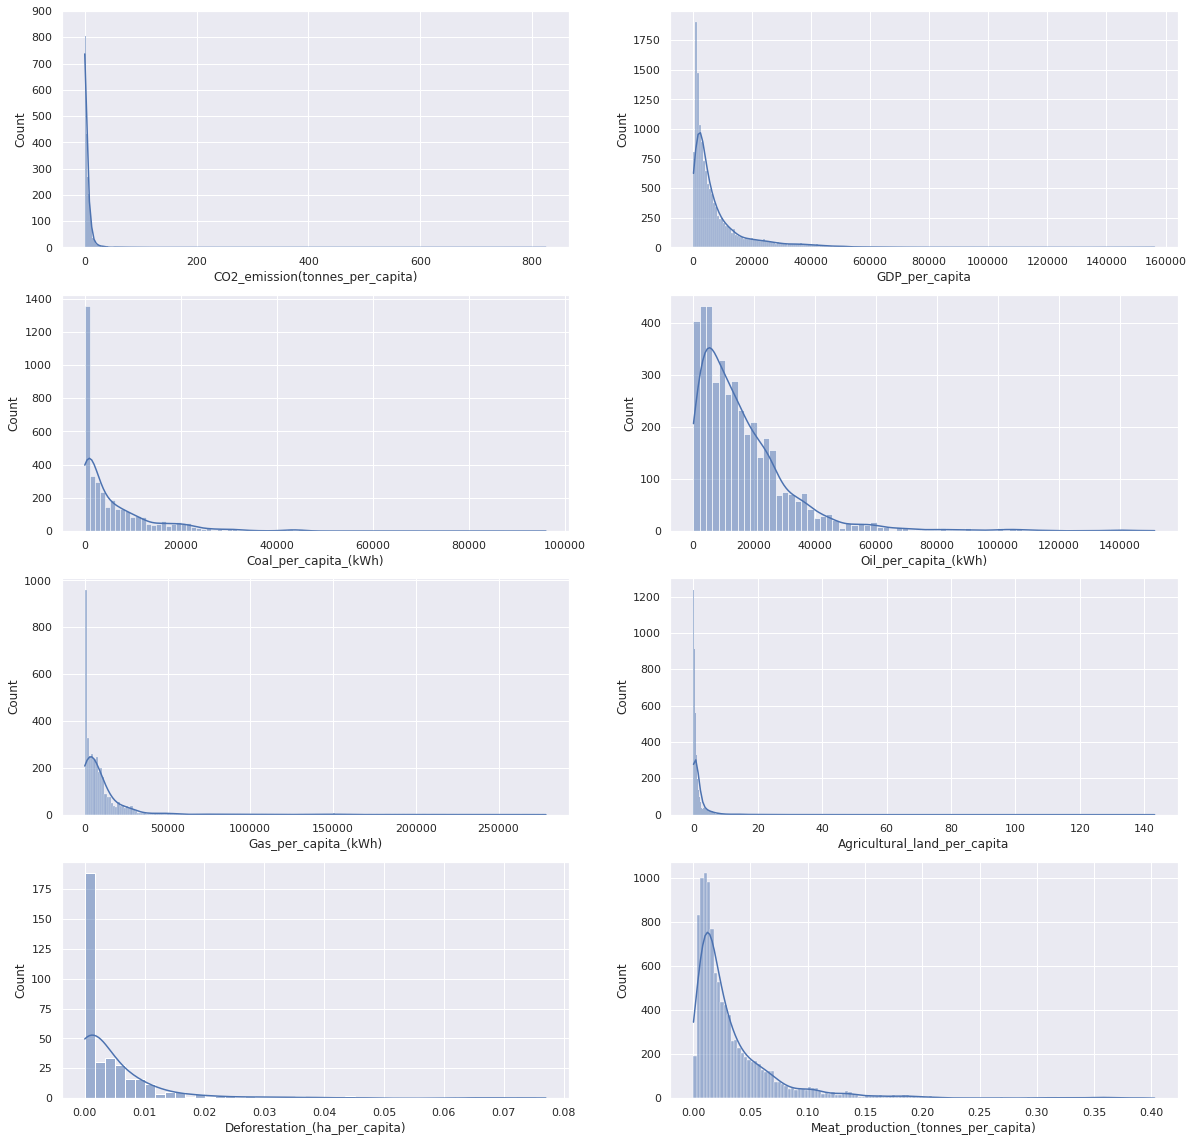

In [ ]:
# Distribution of variables
sns.set(style="darkgrid")
fig, axs = plt.subplots(4, 2, figsize = (20,20))
sns.histplot(co2_emission_predictor_df, x="CO2_emission(tonnes_per_capita)", kde=True, ax=axs[0, 0])
axs[0, 0].set_ylim(0, 900)
sns.histplot(co2_emission_predictor_df, x="GDP_per_capita", kde=True, ax=axs[0, 1])
sns.histplot(co2_emission_predictor_df, x="Coal_per_capita_(kWh)", kde=True, ax=axs[1, 0])
sns.histplot(co2_emission_predictor_df, x="Oil_per_capita_(kWh)", kde=True, ax=axs[1, 1])
sns.histplot(co2_emission_predictor_df, x="Gas_per_capita_(kWh)", kde=True, ax=axs[2, 0])
sns.histplot(co2_emission_predictor_df, x="Agricultural_land_per_capita", kde=True, ax=axs[2, 1])
sns.histplot(co2_emission_predictor_df, x="Deforestation_(ha_per_capita)", kde=True, ax=axs[3, 0])
sns.histplot(co2_emission_predictor_df, x="Meat_production_(tonnes_per_capita)", kde=True, ax=axs[3, 1])

# **Question 1: Data analysis**

In [ ]:
display(co2_emission_predictor_df)

,Country,Country_code,Year,CO2_emission(tonnes_per_capita),Population,GDP_per_capita,Coal_per_capita_(kWh),Oil_per_capita_(kWh),Gas_per_capita_(kWh),Agricultural_land_per_capita,Deforestation_(ha_per_capita),Meat_production_(tonnes_per_capita)
0,Afghanistan,AFG,1949,0.001922,7624058.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1950,0.011266,7480464.0,1156.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1951,0.012098,7571542.0,1170.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1952,0.011946,7667534.0,1189.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1953,0.013685,7764549.0,1240.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23056,Zimbabwe,ZWE,2017,0.650533,14751101.0,1582.366211,NaN,NaN,NaN,1.137913,NaN,0.013754
23057,Zimbabwe,ZWE,2018,0.783639,15052191.0,1611.405151,NaN,NaN,NaN,1.121977,NaN,0.013221
23058,Zimbabwe,ZWE,2019,0.723861,15354606.0,NaN,NaN,NaN,NaN,NaN,NaN,0.012661
23059,Zimbabwe,ZWE,2020,0.676970,15669663.0,NaN,NaN,NaN,NaN,NaN,NaN,0.012364


In [ ]:
# Create dataframe for correlation between CO2 emission and GDP
co2_gdp_correlation_df = co2_emission_predictor_df.iloc[: , [3, 5]].copy()
co2_gdp_correlation_df.dropna(inplace=True)
co2_gdp_correlation_df.drop(11149, inplace=True) # Remove outlier
co2_gdp_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_gdp_correlation_df)

# Calculate global correlation and p-value
pearson_corr_co2_gdp = pearsonr(co2_gdp_correlation_df['CO2_emission(tonnes_per_capita)'], co2_gdp_correlation_df['GDP_per_capita'])
display(pearson_corr_co2_gdp)

# Add correlation and p-value to list
pearson_pvalue_list = []
pearson_pvalue_list.append(['GDP per capita', pearson_corr_co2_gdp[0], pearson_corr_co2_gdp[1]])

(0.6789024010175402, 0.0)

In [ ]:
# Create dataframe for correlation between CO2 emission and Coal consumption
co2_coal_correlation_df = co2_emission_predictor_df.iloc[: , [3, 6]].copy()
co2_coal_correlation_df.dropna(inplace=True)
co2_coal_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_coal_correlation_df)

# Calculate correlation and p-value
pearson_corr_co2_coal = pearsonr(co2_coal_correlation_df['CO2_emission(tonnes_per_capita)'], co2_coal_correlation_df['Coal_per_capita_(kWh)'])
display(pearson_corr_co2_coal)

# Add correlation and p-value to list
pearson_pvalue_list.append(['Coal consumption (kWh per capita)', pearson_corr_co2_coal[0], pearson_corr_co2_coal[1]])

(0.6320112616356756, 0.0)

In [ ]:
# Create dataframe for correlation between CO2 emission and Oil consumption
co2_oil_correlation_df = co2_emission_predictor_df.iloc[: , [3, 7]].copy()
co2_oil_correlation_df.dropna(inplace=True)
co2_oil_correlation_df.drop(11149, inplace=True) # Remove outlier
co2_oil_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_oil_correlation_df)

# Calculate global correlation and p-value
pearson_corr_co2_oil = pearsonr(co2_oil_correlation_df['CO2_emission(tonnes_per_capita)'], co2_oil_correlation_df['Oil_per_capita_(kWh)'])
display(pearson_corr_co2_oil)

# Add correlation and p-value to list
pearson_pvalue_list.append(['Oil consumption (kWh per capita)', pearson_corr_co2_oil[0], pearson_corr_co2_oil[1]])

(0.5393945212768828, 2.31515e-317)

In [ ]:
# Create dataframe for correlation between CO2 emission and Gas consumption
co2_gas_correlation_df = co2_emission_predictor_df.iloc[: , [3, 8]].copy()
co2_gas_correlation_df.dropna(inplace=True)
co2_gas_correlation_df.drop(11149, inplace=True) # Remove outlier
co2_gas_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_gas_correlation_df)

# Calculate global correlation and p-value
pearson_corr_co2_gas = pearsonr(co2_gas_correlation_df['CO2_emission(tonnes_per_capita)'], co2_gas_correlation_df['Gas_per_capita_(kWh)'])
display(pearson_corr_co2_gas)

# Add correlation and p-value to list
pearson_pvalue_list.append(['Gas consumption (kWh per capita)', pearson_corr_co2_gas[0], pearson_corr_co2_gas[1]])

(0.7141365417799583, 0.0)

In [ ]:
# Create dataframe for correlation between CO2 emission and Agricultural land
co2_agricultural_land_correlation_df = co2_emission_predictor_df.iloc[: , [3, 9]].copy()
co2_agricultural_land_correlation_df.dropna(inplace=True)
co2_agricultural_land_correlation_df.drop(11149, inplace=True) # Remove outlier
co2_agricultural_land_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_agricultural_land_correlation_df)

# Calculate global correlation and p-value
pearson_corr_co2_agricultural_land = pearsonr(co2_agricultural_land_correlation_df['CO2_emission(tonnes_per_capita)'], co2_agricultural_land_correlation_df['Agricultural_land_per_capita'])
display(pearson_corr_co2_agricultural_land)

# Add correlation and p-value to list
pearson_pvalue_list.append(['Agricultural land (ha per capita)', pearson_corr_co2_agricultural_land[0], pearson_corr_co2_agricultural_land[1]])

(-0.006567663397487312, 0.5001071653073339)

In [ ]:
# Create dataframe for correlation between CO2 emission and Deforestation
co2_deforestation_correlation_df = co2_emission_predictor_df.iloc[: , [3, 10]].copy()
co2_deforestation_correlation_df.dropna(inplace=True)
co2_deforestation_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_deforestation_correlation_df)

# Calculate global correlation and p-value
pearson_corr_co2_deforestation = pearsonr(co2_deforestation_correlation_df['CO2_emission(tonnes_per_capita)'], co2_deforestation_correlation_df['Deforestation_(ha_per_capita)'])
display(pearson_corr_co2_deforestation)

# Add correlation and p-value to list
pearson_pvalue_list.append(['Deforestation (ha per capita)', pearson_corr_co2_deforestation[0], pearson_corr_co2_deforestation[1]])

(-0.14947318759286313, 0.004370359986194772)

In [ ]:
# Create dataframe for correlation between CO2 emission and Meat production
co2_meat_correlation_df = co2_emission_predictor_df.iloc[: , [3, 11]].copy()
co2_meat_correlation_df.dropna(inplace=True)
co2_meat_correlation_df.drop(11149, inplace=True) # Remove outlier
co2_meat_correlation_df.reset_index(drop=True, inplace=True)

# display(co2_meat_correlation_df)

# Calculate global correlation and p-value
pearson_corr_co2_meat_consumption = pearsonr(co2_meat_correlation_df['CO2_emission(tonnes_per_capita)'], co2_meat_correlation_df['Meat_production_(tonnes_per_capita)'])
display(pearson_corr_co2_meat_consumption)

# Add correlation and p-value to list
pearson_pvalue_list.append(['Meat consumption (tonnes per capita)', pearson_corr_co2_meat_consumption[0], pearson_corr_co2_meat_consumption[1]])

(0.26753186956470604, 1.9075606465514796e-174)

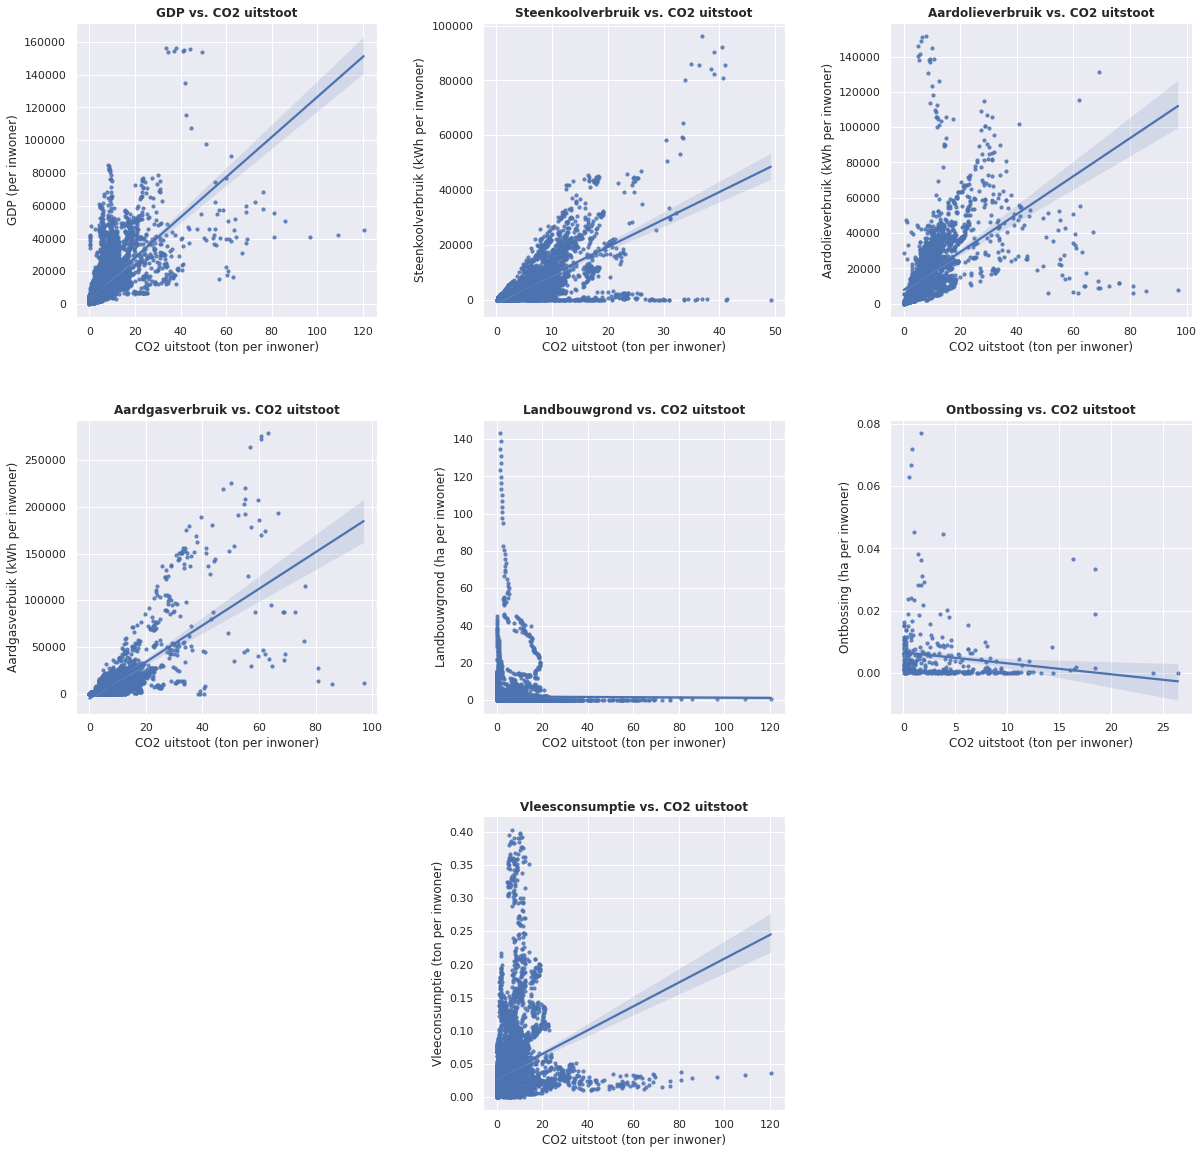

In [ ]:
# Create figure with correlation plots
sns.set(style='darkgrid')
fig, axs = plt.subplots(3, 3, figsize = (20,20))

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='GDP_per_capita', data=co2_gdp_correlation_df, scatter_kws={'s':10}, ax=axs[0, 0])
axs[0, 0].set_title("GDP vs. CO2 uitstoot", fontweight="bold")
axs[0, 0].set_xlabel("CO2 uitstoot (ton per inwoner)")
axs[0, 0].set_ylabel("GDP (per inwoner)")

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='Coal_per_capita_(kWh)', data=co2_coal_correlation_df, scatter_kws={'s':10}, ax=axs[0, 1])
axs[0, 1].set_title('Steenkoolverbruik vs. CO2 uitstoot', fontweight='bold')
axs[0, 1].set_xlabel('CO2 uitstoot (ton per inwoner)')
axs[0, 1].set_ylabel('Steenkoolverbruik (kWh per inwoner)')

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='Oil_per_capita_(kWh)', data=co2_oil_correlation_df, scatter_kws={'s':10}, ax=axs[0, 2])
axs[0, 2].set_title('Aardolieverbruik vs. CO2 uitstoot', fontweight='bold')
axs[0, 2].set_xlabel('CO2 uitstoot (ton per inwoner)')
axs[0, 2].set_ylabel('Aardolieverbruik (kWh per inwoner)')

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='Gas_per_capita_(kWh)', data=co2_gas_correlation_df, scatter_kws={'s':10}, ax=axs[1, 0])
axs[1, 0].set_title('Aardgasverbruik vs. CO2 uitstoot', fontweight='bold')
axs[1, 0].set_xlabel('CO2 uitstoot (ton per inwoner)')
axs[1, 0].set_ylabel('Aardgasverbuik (kWh per inwoner)')

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='Agricultural_land_per_capita', data=co2_agricultural_land_correlation_df, scatter_kws={'s':10}, ax=axs[1, 1])
axs[1, 1].set_title('Landbouwgrond vs. CO2 uitstoot', fontweight='bold')
axs[1, 1].set_xlabel('CO2 uitstoot (ton per inwoner)')
axs[1, 1].set_ylabel('Landbouwgrond (ha per inwoner)')

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='Deforestation_(ha_per_capita)', data=co2_deforestation_correlation_df, scatter_kws={'s':10}, ax=axs[1, 2])
axs[1, 2].set_title('Ontbossing vs. CO2 uitstoot', fontweight='bold')
axs[1, 2].set_xlabel('CO2 uitstoot (ton per inwoner)')
axs[1, 2].set_ylabel('Ontbossing (ha per inwoner)')

sns.regplot(x='CO2_emission(tonnes_per_capita)', y='Meat_production_(tonnes_per_capita)', data=co2_meat_correlation_df, scatter_kws={'s':10}, ax=axs[2, 1])
axs[2, 1].set_title('Vleesconsumptie vs. CO2 uitstoot', fontweight='bold')
axs[2, 1].set_xlabel('CO2 uitstoot (ton per inwoner)')
axs[2, 1].set_ylabel('Vleeconsumptie (ton per inwoner)')

fig.delaxes(axs[2, 0])
fig.delaxes(axs[2, 2])

fig.subplots_adjust(wspace=0.35, hspace=0.35)

,Pearson_correlation,P-value
Variable,,
Gas consumption (kWh per capita),0.714137,0.000000e+00
GDP per capita,0.678902,0.000000e+00
Coal consumption (kWh per capita),0.632011,0.000000e+00
Oil consumption (kWh per capita),0.539395,2.315150e-317
Meat consumption (tonnes per capita),0.267532,1.907561e-174
Deforestation (ha per capita),-0.149473,4.370360e-03
Agricultural land (ha per capita),-0.006568,5.001072e-01


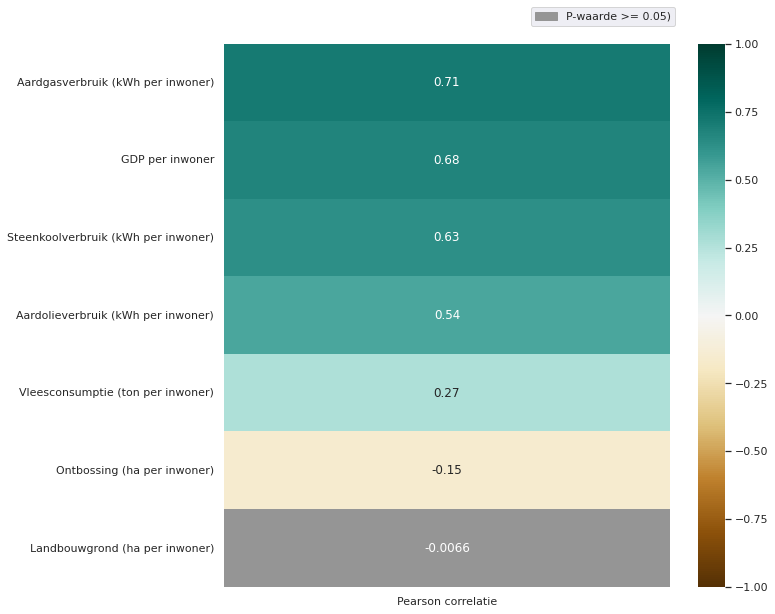

In [ ]:
# Create dataframe with pearson correlation and p-value
correlation_pvalue_df = pd.DataFrame(pearson_pvalue_list, columns=['Variable', 'Pearson_correlation', 'P-value'])
correlation_pvalue_df.set_index('Variable', inplace=True)
correlation_pvalue_df.sort_values(['P-value', 'Pearson_correlation'], inplace=True, ascending=[True, False])
display(correlation_pvalue_df)

# Create heatmap
fig, ax = plt.subplots(figsize = (10, 10))
significance = 0.05
sns.heatmap(correlation_pvalue_df.loc[:, ['Pearson_correlation']].where(correlation_pvalue_df['P-value'] < significance), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sns.heatmap(correlation_pvalue_df.loc[:, ['Pearson_correlation']].where(correlation_pvalue_df['P-value'] >= significance), vmin=-1, vmax=1, cbar=False, annot=True, cmap=sns.color_palette("Greys", n_colors=1, desat=1))
ax.set_ylabel("")
ax.set_xticklabels(['Pearson correlatie'])
ax.set_yticklabels(['Aardgasverbruik (kWh per inwoner)', 'GDP per inwoner', 'Steenkoolverbruik (kWh per inwoner)', 'Aardolieverbruik (kWh per inwoner)', 'Vleesconsumptie (ton per inwoner)', 'Ontbossing (ha per inwoner)', 'Landbouwgrond (ha per inwoner)'])

colors = [sns.color_palette('Greys', n_colors=1, desat=1)[0]]
texts = [f'P-waarde >= {significance})']
patches = [mpatches.Patch(color=colors[i], label='{:s}'.format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')

# **Question 2: Data preparation**

In [ ]:
# Select dataset
co2_emission_df = co2_emission_predictor_df.iloc[:, 0:5]

# Calculate CO2 emission not per capita but per country
co2_emission_df['CO2_emission_country(tonnes)'] = co2_emission_df['CO2_emission(tonnes_per_capita)'] * co2_emission_df['Population']

display(co2_emission_df)

,Country,Country_code,Year,CO2_emission(tonnes_per_capita),Population,CO2_emission_country(tonnes)
0,Afghanistan,AFG,1949,0.001922,7624058.0,1.465600e+04
1,Afghanistan,AFG,1950,0.011266,7480464.0,8.427200e+04
2,Afghanistan,AFG,1951,0.012098,7571542.0,9.160000e+04
3,Afghanistan,AFG,1952,0.011946,7667534.0,9.160000e+04
4,Afghanistan,AFG,1953,0.013685,7764549.0,1.062560e+05
...,...,...,...,...,...,...
23056,Zimbabwe,ZWE,2017,0.650533,14751101.0,9.596071e+06
23057,Zimbabwe,ZWE,2018,0.783639,15052191.0,1.179548e+07
23058,Zimbabwe,ZWE,2019,0.723861,15354606.0,1.111461e+07
23059,Zimbabwe,ZWE,2020,0.676970,15669663.0,1.060790e+07


# **Question 2: Data analysis**

In [ ]:
# Calculate relative change
def calculate_relative_change(groupby_df, column_name):
  relative_change = ((groupby_df[column_name].last()- groupby_df[column_name].first()) / groupby_df[column_name].first()) * 100
  return relative_change

In [ ]:
# # Select data from 1990 up untill the last measurement
# selection_year_df = co2_emission_df[co2_emission_df['Year'] >= 1990].copy()

# # Calculate relative change in comparison to previous year
# selection_year_df['Pct_change_CO2'] = selection_year_df.groupby('Country')['CO2_emission_country(tonnes)'].apply(lambda x: x.pct_change() * 100)
# selection_year_df['Pct_change_population'] = selection_year_df.groupby('Country')['Population'].apply(lambda x: x.pct_change() * 100)

# # Replace NaN values with 0.0
# replace_value(selection_year_df, 'Pct_change_CO2', np.nan, 0)
# replace_value(selection_year_df, 'Pct_change_population', np.nan, 0)

# display(selection_year_df)

In [ ]:
# Select data from 1990 up to and including the last measurement
selection_year_df = co2_emission_df[co2_emission_df['Year'] >= 1990].copy()

# Group dataframe based on country
co2_emission_groupby_df = selection_year_df.groupby('Country')

# Calculate relative change for CO2 emission per capita and population, and amount of years
co2_emission_relative = pd.DataFrame(calculate_relative_change(co2_emission_groupby_df, 'CO2_emission_country(tonnes)'))
population_relative = pd.DataFrame(calculate_relative_change(co2_emission_groupby_df, 'Population'))
amount_of_years = pd.DataFrame(co2_emission_groupby_df['Year'].last() - co2_emission_groupby_df['Year'].first())

# Merge dataframes
relative_change_df = co2_emission_relative.merge(population_relative, on='Country').merge(amount_of_years, on='Country')

# Rename columns
relative_change_df.rename(columns={'CO2_emission_country(tonnes)' : 'Relative_change_CO2_emission(%)', 
                                   'Population' : 'Relative_change_population_(%)', 
                                   'Year' : 'Amount_of_years'},
                          inplace=True)

display(relative_change_df)

,Relative_change_CO2_emission(%),Relative_change_population_(%),Amount_of_years
Country,,,
Afghanistan,486.575991,274.943384,31
Albania,-16.329609,-13.364287,31
Algeria,129.703594,73.124210,31
Andorra,11.355682,47.521926,31
Angola,319.710951,191.696824,31
...,...,...,...
Vietnam,1430.678024,45.664644,31
Wallis and Futuna,51.844980,-13.539580,31
Yemen,31.054152,146.589389,31


In [ ]:
# Select top four countries with biggest decrease in CO2 emission and increase in population
top4_countries = relative_change_df.loc[(relative_change_df['Relative_change_population_(%)'] > 0) & (relative_change_df['Relative_change_CO2_emission(%)'] < 0)].copy()
top4_countries.sort_values(by='Relative_change_CO2_emission(%)', inplace=True)

top4 = top4_countries.head(4)
top4.reset_index(inplace=True)

display(top4)

,Country,Relative_change_CO2_emission(%),Relative_change_population_(%),Amount_of_years
0,Curacao,-61.453018,22.440998,31
1,North Korea,-52.373186,24.867821,31
2,Nauru,-52.148889,30.280665,31
3,Kyrgyzstan,-51.826980,48.535408,31


In [ ]:
# Biggest decrease CO2 and increase population
top4_countries_list = top4['Country'].head(4).to_list()

top4_countries_df = selection_year_df.loc[selection_year_df['Country'].isin(top4_countries_list)].copy()

display(top4_countries_df)

,Country,Country_code,Year,CO2_emission(tonnes_per_capita),Population,CO2_emission_country(tonnes)
5408,Curacao,CUW,1990,30.767607,155461.0,4.783163e+06
5409,Curacao,CUW,1991,24.619501,155033.0,3.816835e+06
5410,Curacao,CUW,1992,20.368341,154387.0,3.144607e+06
5411,Curacao,CUW,1993,31.645310,153396.0,4.854264e+06
5412,Curacao,CUW,1994,30.596958,152103.0,4.653889e+06
...,...,...,...,...,...,...
15017,North Korea,PRK,2017,2.027558,25516318.0,5.173580e+07
15018,North Korea,PRK,2018,1.857773,25638152.0,4.762985e+07
15019,North Korea,PRK,2019,2.048663,25755442.0,5.276422e+07
15020,North Korea,PRK,2020,2.139230,25867474.0,5.533648e+07


In [ ]:
# Create line graphs with two y-axis
def create_line_graph(df, country, title, row_index, column_index):
  country_df = df.loc[df['Country'] == country]

  graph1 = sns.lineplot(data=country_df, x='Year', y='CO2_emission_country(tonnes)', color=sns.color_palette('Reds', n_colors=1, desat=1)[0], ax=axs[row_index, column_index], ci=None)
  graph2 = graph1.twinx()
  graph2.set_ylabel('Populatie')
  graph3 = sns.lineplot(data=country_df, x='Year', y='Population', color=sns.color_palette('Blues', n_colors=1, desat=1)[0], ci=None, ax=graph2)
  axs[row_index, column_index].set_title(f'CO2 uitstoot (ton) en de populatie van {title}', fontweight='bold')
  axs[row_index, column_index].set_ylabel('CO2 uitstoot (ton)')
  axs[row_index, column_index].set_xlabel('Jaar')

  colors = [sns.color_palette('Reds', n_colors=1, desat=1)[0], sns.color_palette('Blues', n_colors=1, desat=1)[0]]
  texts = ['CO2 uitstoot', 'Populatie']
  patches = [mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts))]
  axs[row_index, column_index].legend(handles=patches, bbox_to_anchor=(0.50, 0.9), loc='center')

  return graph1, graph3

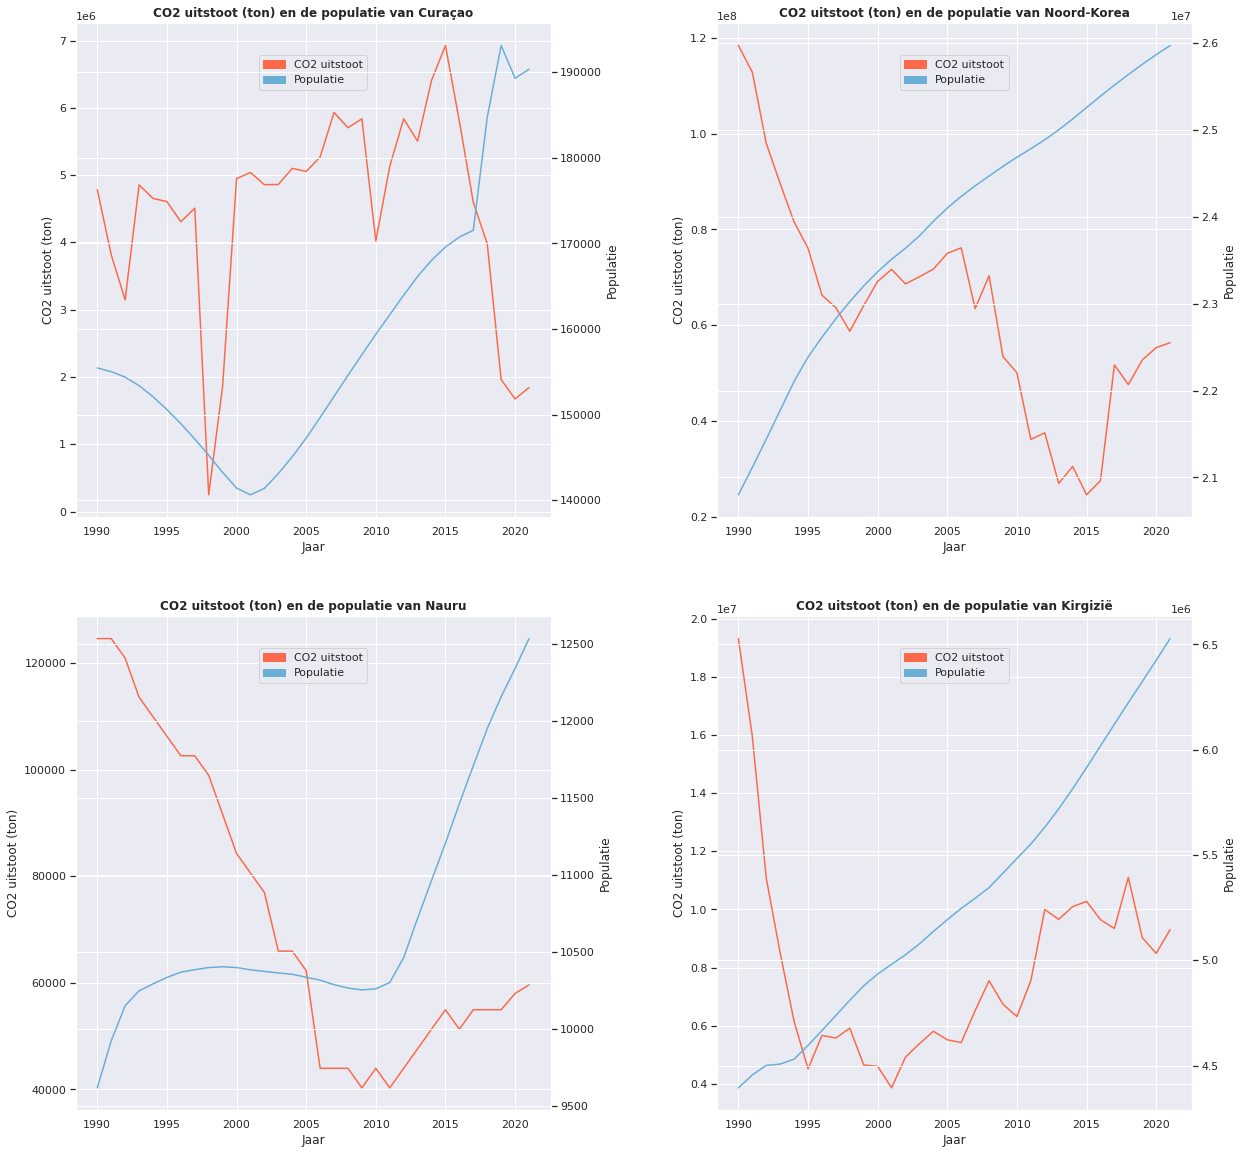

In [ ]:
sns.set(style='darkgrid')
fig, axs = plt.subplots(2, 2, figsize = (20,20))

create_line_graph(top4_countries_df, 'Curacao', 'Curaçao', 0, 0)
create_line_graph(top4_countries_df, 'North Korea', 'Noord-Korea', 0, 1)
create_line_graph(top4_countries_df, 'Nauru', 'Nauru', 1, 0)
create_line_graph(top4_countries_df, 'Kyrgyzstan', 'Kirgizië', 1, 1)

fig.subplots_adjust(wspace=0.35)

# **Question 3: Data preparation**

In [ ]:
# Read dataset
price_renewable_energy = pd.read_csv('/content/drive/MyDrive/EindopdrachtWinc/LevelizedCostOfEnergy.csv')

# Rename columns
new_column_names = ['Country', 'Country_code', 'Year', 'Bioenergy', 'Geothermal_energy', 'Offshore_wind_energy', 'Solar_photovoltaic_energy', 'Concentrated_solar_power', 'Hydropower', 'Onshore_wind_energy']
price_renewable_energy.columns = new_column_names

# Sort based on year
price_renewable_energy.sort_values('Year', inplace=True)

display(price_renewable_energy)

,Country,Country_code,Year,Bioenergy,Geothermal_energy,Offshore_wind_energy,Solar_photovoltaic_energy,Concentrated_solar_power,Hydropower,Onshore_wind_energy
469,World,OWID_WRL,1983,NaN,NaN,NaN,NaN,NaN,NaN,0.327851
86,Denmark,DNK,1984,NaN,NaN,NaN,NaN,NaN,NaN,0.237175
470,World,OWID_WRL,1984,NaN,NaN,NaN,NaN,NaN,NaN,0.320074
159,Germany,DEU,1984,NaN,NaN,NaN,NaN,NaN,NaN,0.252981
323,Sweden,SWE,1984,NaN,NaN,NaN,NaN,NaN,NaN,0.252337
...,...,...,...,...,...,...,...,...,...,...
458,World,OWID_WRL,2021,0.067343,0.067616,0.075167,0.048346,0.114242,0.0483,0.033123
221,Italy,ITA,2021,NaN,NaN,NaN,0.050710,NaN,NaN,0.040854
158,Germany,DEU,2021,NaN,NaN,NaN,0.060541,NaN,NaN,0.051362
59,Canada,CAN,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.029626


In [ ]:
price_renewable_energy_world = price_renewable_energy.loc[price_renewable_energy['Country'] == 'World']
display(price_renewable_energy_world)

,Country,Country_code,Year,Bioenergy,Geothermal_energy,Offshore_wind_energy,Solar_photovoltaic_energy,Concentrated_solar_power,Hydropower,Onshore_wind_energy
469,World,OWID_WRL,1983,NaN,NaN,NaN,NaN,NaN,NaN,0.327851
470,World,OWID_WRL,1984,NaN,NaN,NaN,NaN,NaN,NaN,0.320074
471,World,OWID_WRL,1985,NaN,NaN,NaN,NaN,NaN,NaN,0.297221
472,World,OWID_WRL,1986,NaN,NaN,NaN,NaN,NaN,NaN,0.264194
473,World,OWID_WRL,1987,NaN,NaN,NaN,NaN,NaN,NaN,0.256420
474,World,OWID_WRL,1988,NaN,NaN,NaN,NaN,NaN,NaN,0.212157
475,World,OWID_WRL,1989,NaN,NaN,NaN,NaN,NaN,NaN,0.196435
476,World,OWID_WRL,1990,NaN,NaN,NaN,NaN,NaN,NaN,0.208688
477,World,OWID_WRL,1991,NaN,NaN,NaN,NaN,NaN,NaN,0.200317
478,World,OWID_WRL,1992,NaN,NaN,NaN,NaN,NaN,NaN,0.200653


# **Question 3: Data analysis**

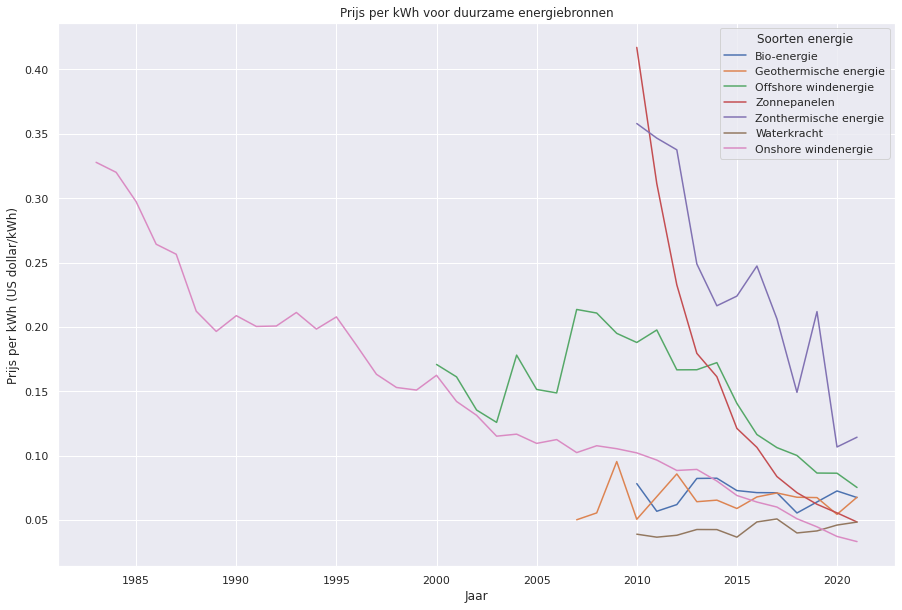

In [ ]:
# Explore data
df = price_renewable_energy_world.copy()
df.drop(['Country', 'Country_code'], axis=1, inplace=True)

df = df.melt(id_vars=['Year'], value_name='Values', var_name='Variables')
# display(df)

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (15,10))
sns.lineplot(data=df, x='Year', y='Values', hue='Variables', palette='deep')
ax.set_ylabel('Prijs per kWh (US dollar/kWh)')
ax.set_xlabel('Jaar')
ax.set_title('Prijs per kWh voor duurzame energiebronnen')
plt.legend(title='Soorten energie', labels=['Bio-energie', 'Geothermische energie', 'Offshore windenergie', 'Zonnepanelen', 'Zonthermische energie', 'Waterkracht', 'Onshore windenergie'])

In [ ]:
# https://www.kdnuggets.com/2019/03/beginners-guide-linear-regression-python-scikit-learn.html
# https://stackabuse.com/linear-regression-in-python-with-scikit-learn/

def prepare_dataset(df, x_column, y_column):
  # Create dataframe with selection data
  selection_df = df.loc[:, [x_column, y_column]]
  selection_df.dropna(inplace=True)

  # Create stistical summary
  display(selection_df.describe())

  return selection_df


def linear_regression(selection_df, x_column, y_column):
  # Divide data to get x- and y-values
  x = selection_df[x_column].values.reshape(-1, 1)
  y = selection_df[y_column].values.reshape(-1, 1)

  # Divide data in train and test set
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # Train model
  regressor = LinearRegression()
  regressor.fit(x_train, y_train)

  reg_intercept = regressor.intercept_[0]
  reg_coef = regressor.coef_[0][0]

  print(f'The intercept value is: {reg_intercept}\nThe slope value is: {reg_coef}')

  # Test model
  y_pred = regressor.predict(x_test)
  pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

  pred_df2 = pred_df.head(25)
  pred_df2.plot(kind='bar',figsize=(16,10))
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.show()

  # Plot the straight line with the test data
  plt.scatter(x_test, y_test,  color='gray')
  plt.plot(x_test, y_pred, color='red', linewidth=2)
  plt.show()

  # Evaluate model
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  print(f'Mean absolute error: {mae:.2f}')
  print(f'Mean squared error: {mse:.2f}')
  print(f'Root mean squared error: {rmse:.2f}')

  return reg_intercept, reg_coef


def calculate_future_data(selection_df, reg_coef, reg_intercept, x_column, y_column):
  x_values = range(2022, 2051)
  future_data = []

  for x in x_values:
    y_value = (reg_intercept * x) + reg_coef
    future_data.append([x, y_value])

  future_data_df = pd.DataFrame(future_data)
  future_data_df.columns = [x_column, y_column]

  frames = [selection_df, future_data_df]
  selection_with_future_data = pd.concat(frames)
  selection_with_future_data.reset_index(inplace=True)
  selection_with_future_data.drop(['index'], axis=1, inplace=True)

  return selection_with_future_data

,Year,Bioenergy
count,12.000000,12.000000
mean,2015.500000,0.069621
std,3.605551,0.008970
min,2010.000000,0.055360
25%,2012.750000,0.063420
50%,2015.500000,0.071124
75%,2018.250000,0.074126
max,2021.000000,0.082375


The intercept value is: 0.4150174026606156
The slope value is: -0.00017170963268156478


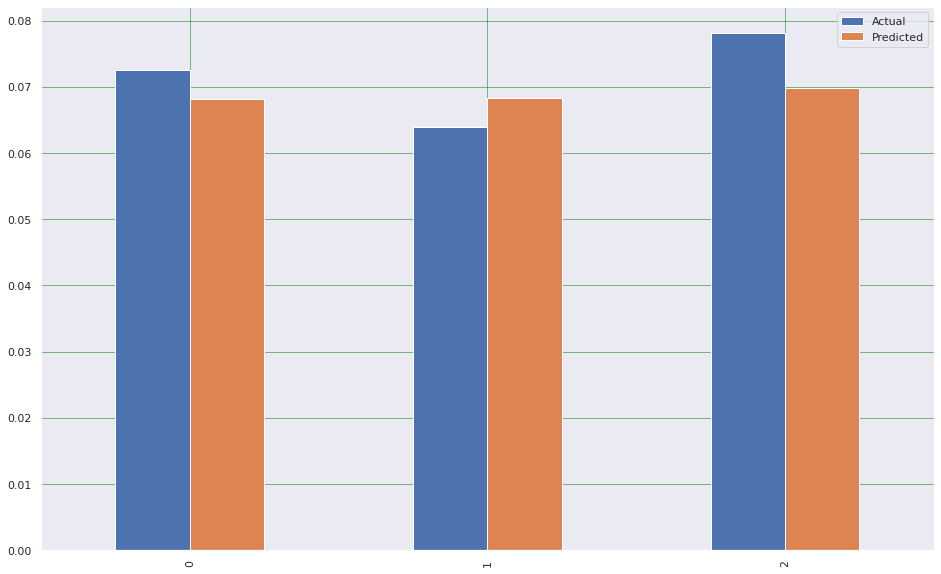

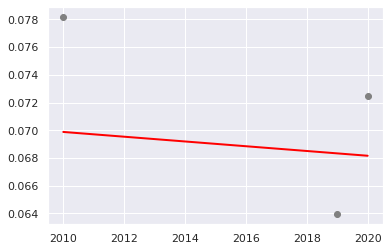

Mean absolute error: 0.01
Mean squared error: 0.00
Root mean squared error: 0.01


,Year,Bioenergy
0,2010,0.078189
1,2011,0.056684
2,2012,0.061879
3,2013,0.082198
4,2014,0.082375
5,2015,0.072771
6,2016,0.071178
7,2017,0.071070
8,2018,0.055360
9,2019,0.063933


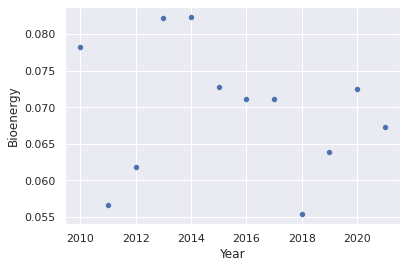

In [ ]:
# Bioenergy
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Bioenergy")
intercept_and_coef = linear_regression(selection_data_df, 'Year', "Bioenergy")
future_data_bioenergy = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "Bioenergy")
display(future_data_bioenergy)

sns.scatterplot(data=price_renewable_energy_world, x="Year", y="Bioenergy")

,Year,Geothermal_energy
count,14.000000,14.000000
mean,2014.214286,0.065767
std,4.560340,0.012652
min,2007.000000,0.050078
25%,2010.500000,0.056281
50%,2014.500000,0.066320
75%,2017.750000,0.067755
max,2021.000000,0.095317


The intercept value is: 1.310742133294574
The slope value is: -0.0006176982112403101


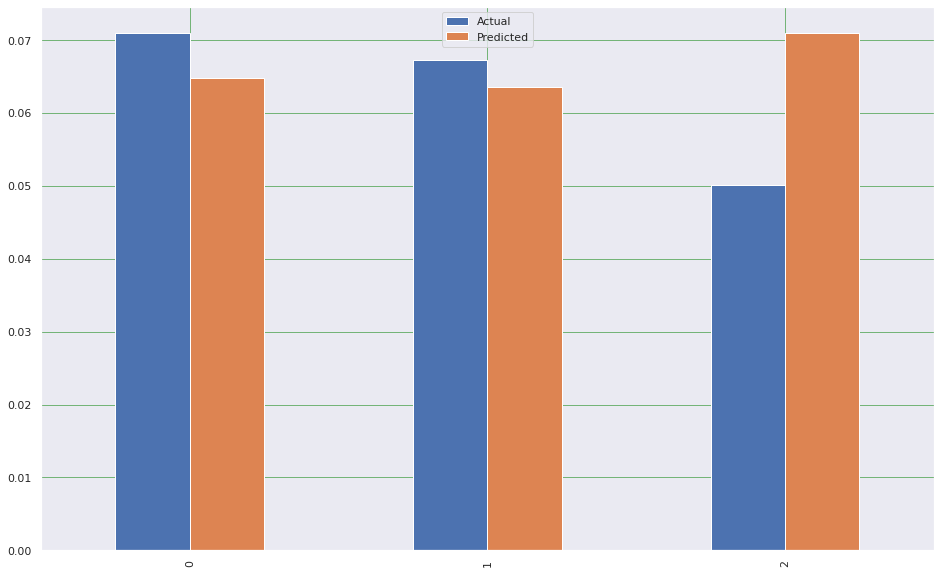

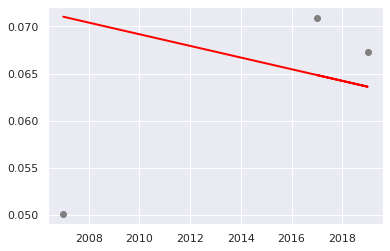

Mean absolute error: 0.01
Mean squared error: 0.00
Root mean squared error: 0.01


,Year,Geothermal_energy
0,2007,0.050078
1,2008,0.055425
2,2009,0.095317
3,2010,0.050445
4,2012,0.085695
5,2013,0.064111
6,2014,0.065335
7,2015,0.058849
8,2016,0.067802
9,2017,0.070917


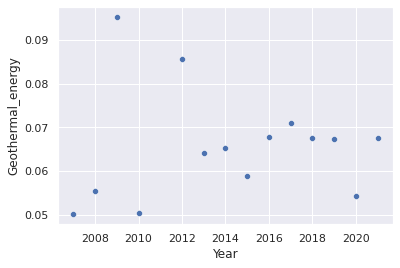

In [ ]:
# Geothermal energy
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Geothermal_energy")
intercept_and_coef = linear_regression(selection_data_df, 'Year', "Geothermal_energy")
future_data_geothermal = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "Geothermal_energy")
display(future_data_geothermal)

sns.scatterplot(data=price_renewable_energy_world, x="Year", y="Geothermal_energy")

,Year,Offshore_wind_energy
count,22.000000,22.000000
mean,2010.500000,0.149635
std,6.493587,0.041389
min,2000.000000,0.075167
25%,2005.250000,0.118681
50%,2010.500000,0.156240
75%,2015.750000,0.176567
max,2021.000000,0.213507


The intercept value is: 8.774159374352877
The slope value is: -0.0042907690569690266


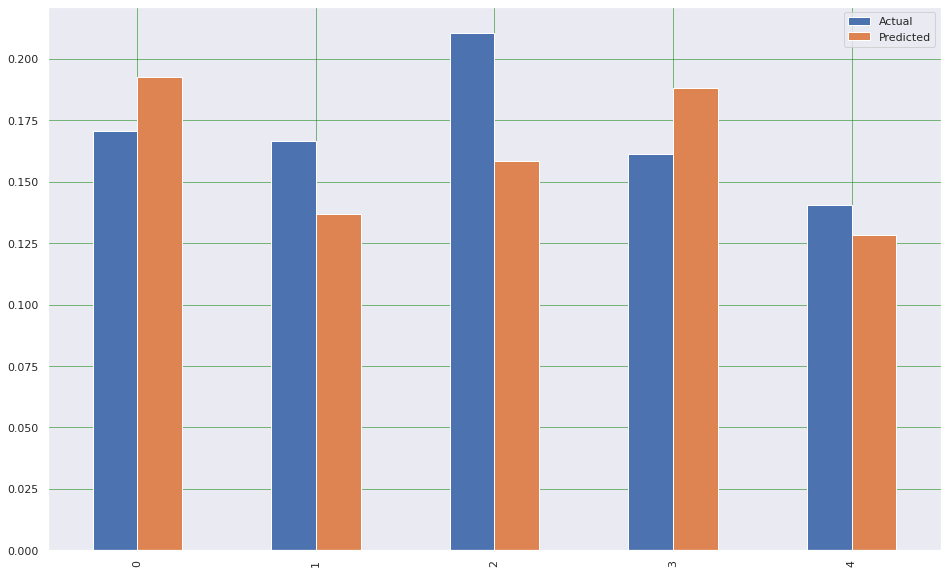

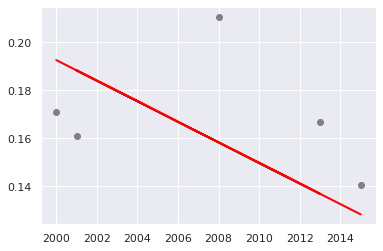

Mean absolute error: 0.03
Mean squared error: 0.00
Root mean squared error: 0.03


,Year,Offshore_wind_energy
0,2000,0.170783
1,2001,0.161125
2,2002,0.135365
3,2003,0.125755
4,2004,0.178023
5,2005,0.151355
6,2006,0.148653
7,2007,0.213507
8,2008,0.210723
9,2009,0.194945


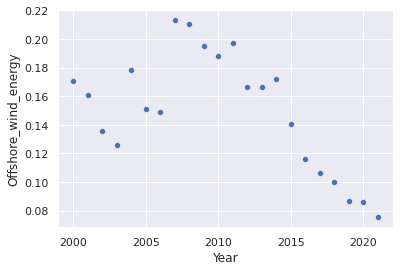

In [ ]:
# Offshore wind energy
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Offshore_wind_energy")
intercept_and_coef = linear_regression(selection_data_df, 'Year', "Offshore_wind_energy")
future_data_offshore_wind = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "Offshore_wind_energy")
display(future_data_offshore_wind)

sns.scatterplot(data=price_renewable_energy_world, x="Year", y="Offshore_wind_energy")

,Year,Solar_photovoltaic_energy
count,12.000000,12.000000
mean,2015.500000,0.154156
std,3.605551,0.114954
min,2010.000000,0.048346
25%,2012.750000,0.068884
50%,2015.500000,0.113710
75%,2018.250000,0.192709
max,2021.000000,0.417149


The intercept value is: 374.2188835872285
The slope value is: -0.18672570126944477


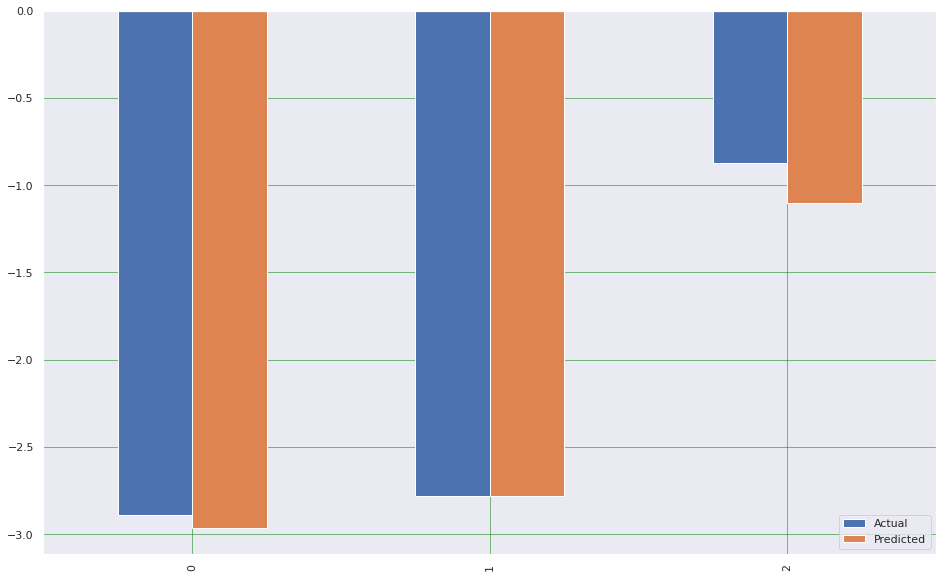

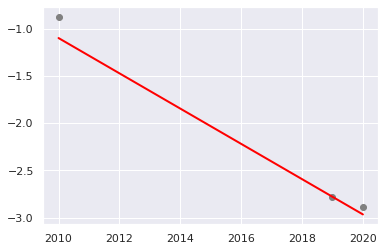

Mean absolute error: 0.10
Mean squared error: 0.02
Root mean squared error: 0.14


,Year,Solar_photovoltaic_energy,natural_log,reverse_log
0,2010,0.417149,-0.874313,0.417149
1,2011,0.311298,-1.167004,0.311298
2,2012,0.232633,-1.458292,0.232633
3,2013,0.179401,-1.718130,0.179401
4,2014,0.161258,-1.824749,0.161258
5,2015,0.121080,-2.111305,0.121080
6,2016,0.106340,-2.241110,0.106340
7,2017,0.083660,-2.480997,0.083660
8,2018,0.071139,-2.643124,0.071139
9,2019,0.062119,-2.778701,0.062119


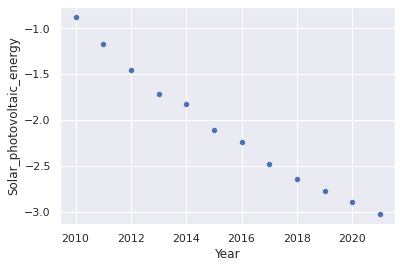

In [ ]:
# Solar photovoltaic energy
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Solar_photovoltaic_energy")

selection_data_df['natural_log'] = np.log(selection_data_df['Solar_photovoltaic_energy'])
intercept_and_coef = linear_regression(selection_data_df, 'Year', "natural_log")
future_data_solar_photovoltaic = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "natural_log")
future_data_solar_photovoltaic['reverse_log'] = np.exp(future_data_solar_photovoltaic['natural_log'])
display(future_data_solar_photovoltaic)

# x_data = selection_data_df['Year']
y_data = np.log(selection_data_df['Solar_photovoltaic_energy'])

sns.scatterplot(data=price_renewable_energy_world, x="Year", y=y_data)

,Year,Concentrated_solar_power
count,12.000000,12.000000
mean,2015.500000,0.230558
std,3.605551,0.084474
min,2010.000000,0.106653
25%,2012.750000,0.191936
50%,2015.500000,0.220133
75%,2018.250000,0.271060
max,2021.000000,0.358004


The intercept value is: 45.46155802449722
The slope value is: -0.022443833715083805


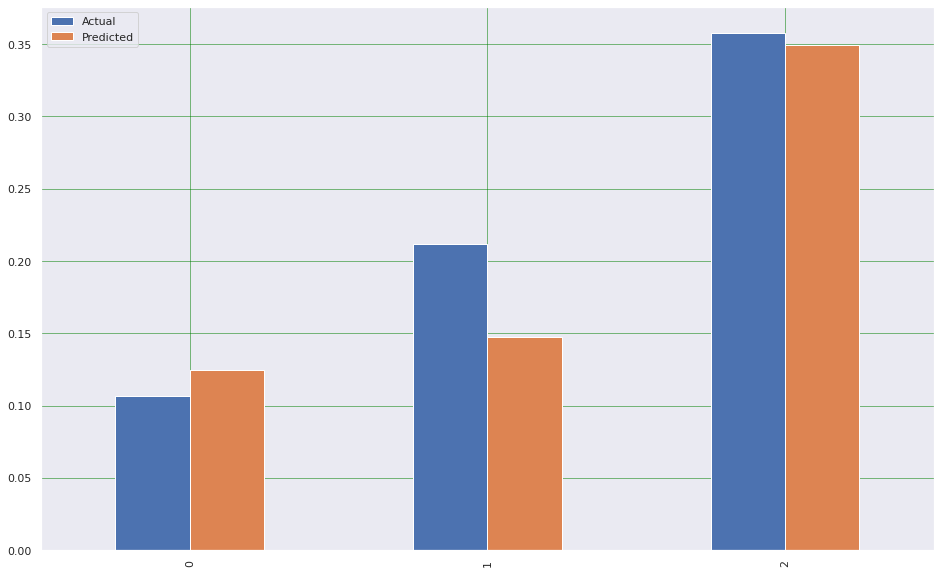

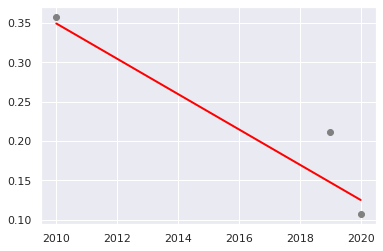

Mean absolute error: 0.03
Mean squared error: 0.00
Root mean squared error: 0.04


,Year,Concentrated_solar_power
0,2010,0.358004
1,2011,0.346655
2,2012,0.337574
3,2013,0.248888
4,2014,0.216377
5,2015,0.223889
6,2016,0.247269
7,2017,0.206213
8,2018,0.149103
9,2019,0.211831


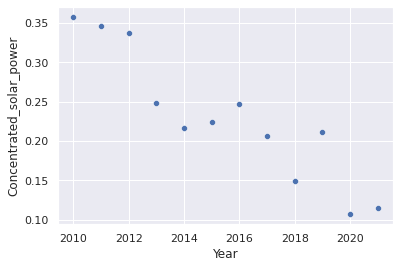

In [ ]:
# Concentrated solar power
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Concentrated_solar_power")
intercept_and_coef = linear_regression(selection_data_df, 'Year', "Concentrated_solar_power")
future_data_concentrated_solar = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "Concentrated_solar_power")
display(future_data_concentrated_solar)

sns.scatterplot(data=price_renewable_energy_world, x="Year", y="Concentrated_solar_power")

,Year,Hydropower
count,12.000000,12.000000
mean,2015.500000,0.042470
std,3.605551,0.004858
min,2010.000000,0.036561
25%,2012.750000,0.038671
50%,2015.500000,0.041933
75%,2018.250000,0.046549
max,2021.000000,0.050722


The intercept value is: -2.138596386980448
The slope value is: 0.0010823595055865925


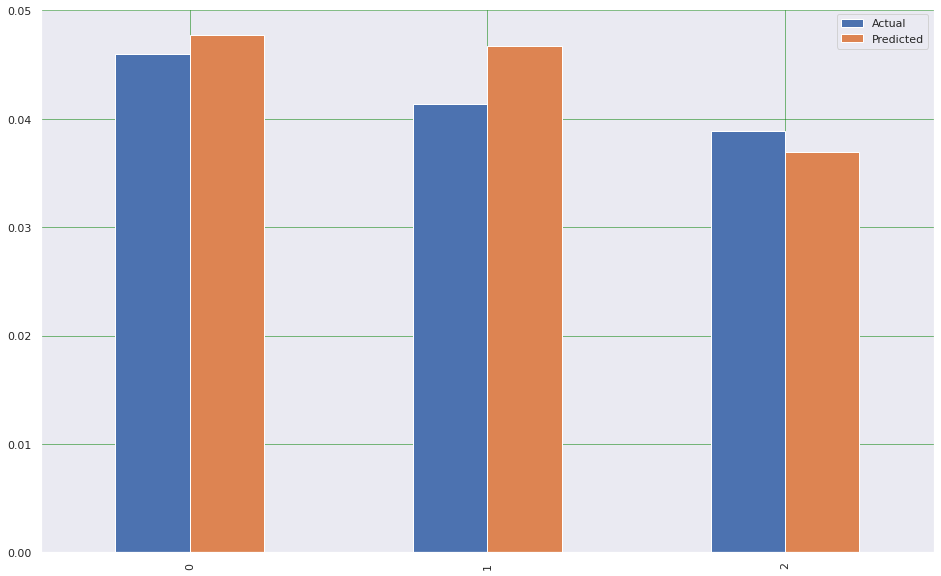

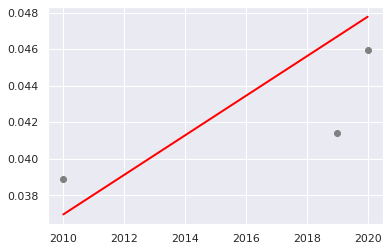

Mean absolute error: 0.00
Mean squared error: 0.00
Root mean squared error: 0.00


,Year,Hydropower
0,2010,0.038883
1,2011,0.036561
2,2012,0.038038
3,2013,0.042512
4,2014,0.042457
5,2015,0.036572
6,2016,0.048389
7,2017,0.050722
8,2018,0.039837
9,2019,0.041409


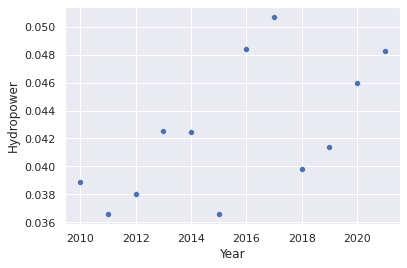

In [ ]:
# Concentrated hydropower
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Hydropower")
intercept_and_coef = linear_regression(selection_data_df, 'Year', "Hydropower")
future_data_hydropower = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "Hydropower")
display(future_data_hydropower)

sns.scatterplot(data=price_renewable_energy_world, x="Year", y="Hydropower")

,Year,Onshore_wind_energy
count,39.000000,39.000000
mean,2002.000000,0.148025
std,11.401754,0.077943
min,1983.000000,0.033123
25%,1992.500000,0.092846
50%,2002.000000,0.131277
75%,2011.500000,0.200485
max,2021.000000,0.327851


The intercept value is: 13.84848802208911
The slope value is: -0.006843658942919171


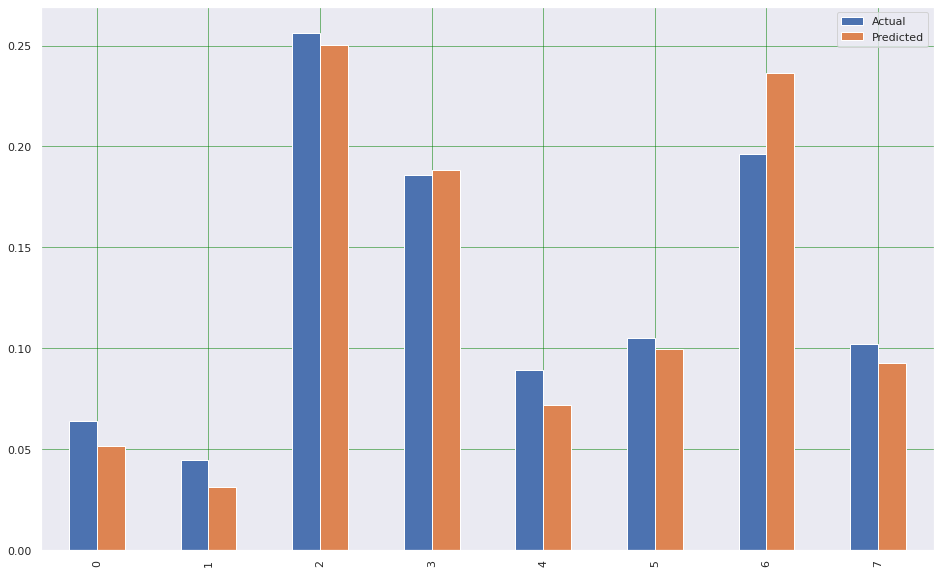

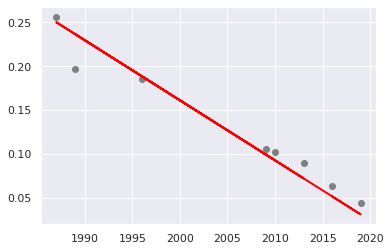

Mean absolute error: 0.01
Mean squared error: 0.00
Root mean squared error: 0.02


,Year,Onshore_wind_energy
0,1983,0.327851
1,1984,0.320074
2,1985,0.297221
3,1986,0.264194
4,1987,0.256420
...,...,...
63,2046,-0.153638
64,2047,-0.160482
65,2048,-0.167325
66,2049,-0.174169


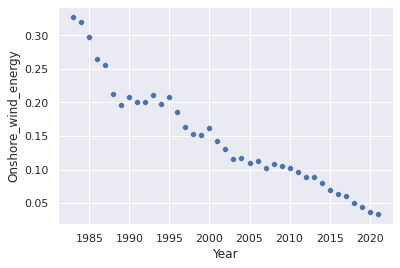

In [ ]:
# Onshore wind energy
selection_data_df = prepare_dataset(price_renewable_energy_world, 'Year', "Onshore_wind_energy")
intercept_and_coef = linear_regression(selection_data_df, 'Year', "Onshore_wind_energy")
future_data_onshore_wind = calculate_future_data(selection_data_df, intercept_and_coef[0], intercept_and_coef[1], 'Year', "Onshore_wind_energy")
display(future_data_onshore_wind)

sns.scatterplot(data=price_renewable_energy_world, x="Year", y="Onshore_wind_energy")

In [ ]:
# Merge dataframes with calculated future data
data_frames = [future_data_onshore_wind, future_data_hydropower, future_data_concentrated_solar, future_data_solar_photovoltaic, future_data_offshore_wind, future_data_geothermal, future_data_bioenergy]

future_data_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'], how='left'), data_frames)
future_data_df.drop(columns=['natural_log', "Solar_photovoltaic_energy"], inplace=True)
future_data_df.rename(columns={"reverse_log" : "Solar_photovoltaic_energy"}, inplace=True)
display(future_data_df)

,Year,Onshore_wind_energy,Hydropower,Concentrated_solar_power,Solar_photovoltaic_energy,Offshore_wind_energy,Geothermal_energy,Bioenergy
0,1983,0.327851,NaN,NaN,NaN,NaN,NaN,NaN
1,1984,0.320074,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,0.297221,NaN,NaN,NaN,NaN,NaN,NaN
3,1986,0.264194,NaN,NaN,NaN,NaN,NaN,NaN
4,1987,0.256420,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
63,2046,-0.153638,0.075911,-0.458526,0.000401,-0.004754,0.046932,0.063699
64,2047,-0.160482,0.076994,-0.480970,0.000333,-0.009045,0.046314,0.063528
65,2048,-0.167325,0.078076,-0.503413,0.000276,-0.013336,0.045696,0.063356
66,2049,-0.174169,0.079158,-0.525857,0.000229,-0.017626,0.045078,0.063184


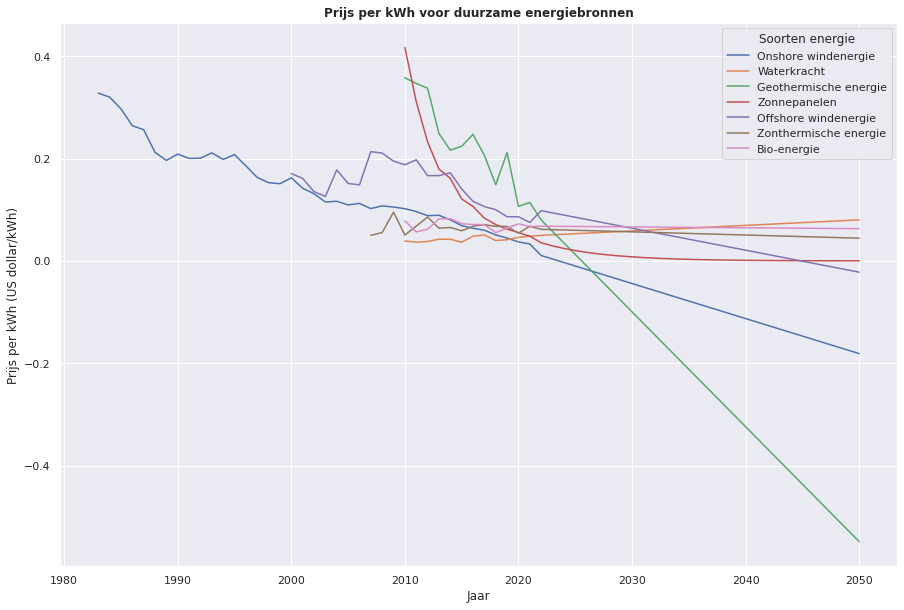

In [ ]:
# Plot data
future_data_plot_df = future_data_df.copy()
future_data_plot_df = future_data_plot_df.melt(id_vars=['Year'], value_name='Values', var_name='Variables')
# display(df)

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize = (15,10))
sns.lineplot(data=future_data_plot_df, x="Year", y="Values", hue="Variables", palette="deep")
ax.set_ylabel('Prijs per kWh (US dollar/kWh)')
ax.set_xlabel('Jaar')
ax.set_title('Prijs per kWh voor duurzame energiebronnen', fontweight='bold')
plt.legend(title='Soorten energie', labels=['Onshore windenergie', 'Waterkracht', 'Geothermische energie', 'Zonnepanelen', 'Offshore windenergie', 'Zonthermische energie', 'Bio-energie'])